In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime


In [75]:
config = json.loads(open('config.json').read()) 
cifar_model_path = config["local"]["model_path"]
train= True
save_model = True

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)  # 10 is the number of classes
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [76]:


# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
shear_range=0.2,    
zoom_range=0.2,
horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data
test_datagen = ImageDataGenerator(rescale=1./255)


# Create Training Set Generator
train_set = train_datagen.flow(
    x_train, y_train,        # Path to the folder containing training images     # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
) 

val_set = val_datagen.flow(
    x_val, y_val, 
    batch_size=32
)

test_set = test_datagen.flow(
    x_test, y_test, 
    batch_size=32
)

In [77]:


# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  
])

In [78]:
# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = True
if early_stopping:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
else:
    early_stopping = None


# Train the Model
history = classifier.fit(
    train_set,
    epochs=200,
    validation_data=val_set,
    callbacks=[early_stopping]
)
    



Epoch 1/200
1250/1250 [==============================] - ETA: 0s - loss: 1.6188 - accuracy: 0.4069

KeyboardInterrupt: 

### Prediction of Single Image

1/1 [==============================] - 0s 49ms/step
Predicted Label: 9
True Label: [9]


Text(0, 0, 'Predicted Label: 9')

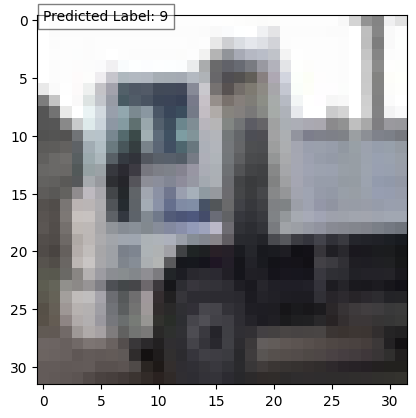

In [ ]:
#get random image from train_set_folder
all_files = []
random_int= random.randint(0, x_train.shape[0]) 
to_plot= x_train[random_int]
label= y_train[random_int]
to_plot = np.expand_dims(to_plot, axis=0)
# Make prediction
prediction = classifier.predict(to_plot)  # No need for batch_size or steps arguments
predicted_label = np.argmax(prediction)
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {label}")
plt.imshow(to_plot[0])
plt.text(0, 0, f"Predicted Label: {predicted_label}", bbox=dict(facecolor='white', alpha=0.5))



In [ ]:
# Reset the generator before prediction
val_set.reset()
steps  = math.ceil(x_val.shape[0] / val_set.batch_size)
# Use predict with steps argument
predictions = classifier.predict(val_set, steps=steps)
df = pd.DataFrame({
    'predict': predictions.argmax(axis=1),
    'y': y_val.flatten()
})


10000/10000 [==============================] - 6s 610us/step


In [ ]:
misclassified = df[df['y']!=df['predict']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 9041


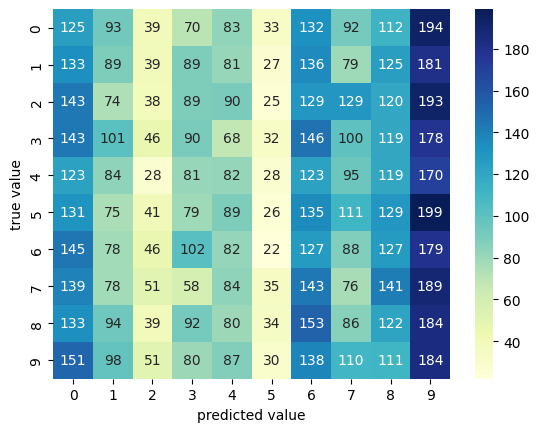

In [ ]:
conf_matrix = confusion_matrix(df.y,df.predict)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

## New model for Cifar-10, based on VGG16 architecture


Redefine Model using: 
1) Additional layers to add robustness to the model
2) Normalisation for model stability
3) Additional dropout to prevent overfitting

In [67]:
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, Input, Dense, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# import activation function
from tensorflow.keras.layers import Activation

# import the backend
from tensorflow.keras import backend as K

if train: 
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization

    model = Sequential()


    model.add(Conv2D(32, kernel_size=(3, 3), input_shape=x_train.shape[1:], activation ="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=x_train.shape[1:], activation ="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), input_shape=x_train.shape[1:], activation ="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    print(model.summary())

    opt = Adadelta(learning_rate=1.0, rho=0.95, epsilon=None)
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    history = model.fit(
        train_set,
        epochs=200,
        validation_data=val_set,
        callbacks=[early_stopping]
    )
        
    if save_model:
        model.save(cifar_model_path)
else:
    model = tf.keras.models.load_model(cifar_model_path)
    print("Model loaded from disk")
    


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_119 (Conv2D)         (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_79 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_62 (Dropout)        (None, 15, 15, 32)        0         
                                                                 
 conv2d_120 (Conv2D)         (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_80 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 dropout_63 (Dropout)        (None, 6, 6, 64)        

None
Epoch 1/200
1250/1250 [==============================] - 14s 11ms/step - loss: 1.8029 - accuracy: 0.1204 - val_loss: 1.4380 - val_accuracy: 0.0688
Epoch 2/200
 379/1250 [========>.....................] - ETA: 10s - loss: 1.5208 - accuracy: 0.0998

KeyboardInterrupt: 

In [72]:
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta
import tensorflow as tf
from keras import regularizers

if train:
    model = Sequential()

    weight_decay = 1e-4
    model2 = Sequential()
    model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model2.add(Activation('elu'))
    model2.add(BatchNormalization())
    model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Activation('elu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.2))
    
    model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Activation('elu'))
    model2.add(BatchNormalization())
    model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Activation('elu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.3))
    
    model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Activation('elu'))
    model2.add(BatchNormalization())
    model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model2.add(Activation('elu'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.4))
    
    model2.add(Flatten())
    model2.add(Dense(10, activation='softmax'))
    
    model2.summary()
    print(model2.summary())

    # Compile the model
    opt = Adadelta(learning_rate=1.0, rho=0.95, epsilon=None)
    model2.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Train the model
    history = model2.fit(
        train_set,
        epochs=200,
        validation_data=val_set,
        callbacks=[early_stopping]
    )

    # Save the model
    if save_model:
        model.save(cifar_model_path)
else:
    model = tf.keras.models.load_model(cifar_model_path)
    print("Model loaded from disk")




Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 activation_36 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_36 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_129 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 activation_37 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_37 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                   

None
Epoch 1/200
1250/1250 [==============================] - 69s 55ms/step - loss: 1.8410 - accuracy: 0.4470 - val_loss: 1.3296 - val_accuracy: 0.5835
Epoch 2/200
1085/1250 [=========================>....] - ETA: 8s - loss: 1.1619 - accuracy: 0.6275

KeyboardInterrupt: 